In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchtext
import os
from pathlib import Path

In [2]:
PATH = Path('./data')
os.listdir(PATH)

['sample_submission.csv',
 'submission.csv',
 'test.csv',
 'test_clean.csv',
 'train.csv',
 'train_clean.csv']

In [4]:
ID = torchtext.data.RawField()
KEYWORD = torchtext.data.RawField()
LOCATION = torchtext.data.RawField()
TEXT = torchtext.data.Field(tokenize="spacy")
LABEL = torchtext.data.LabelField(dtype = torch.long)

dataset = torchtext.data.TabularDataset(
    path = PATH / 'train.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT), ('target', LABEL)],
    skip_header = True
)

len(dataset)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:36: UserWarning: RawField class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\field.py:150: UserWarning: LabelField class will be retired in the 0.8.0 release and moved to torc

7613

In [5]:
ix = 0
print(vars(dataset.examples[ix]))

{'id': '1', 'keyword': '', 'location': '', 'text': ['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all'], 'target': '1'}


In [6]:
train_dataset, valid_dataset = dataset.split(
    split_ratio=0.6,
    stratified=True,
    strata_field='target'
)

len(train_dataset), len(valid_dataset)

(4568, 3045)

In [7]:
MAX_VOCAB_SIZE = 10000

TEXT.build_vocab(train_dataset, 
                 max_size=MAX_VOCAB_SIZE,
                 vectors="glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_dataset)

In [8]:
len(TEXT.vocab), len(LABEL.vocab)

(10002, 2)

In [9]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', '#', '?', '.', 'the', ':', 'a', 'in', 'to']

In [10]:
TEXT.vocab.freqs.most_common(10)

[('#', 1987),
 ('?', 1891),
 ('.', 1781),
 ('the', 1563),
 (':', 1159),
 ('a', 1146),
 ('in', 1067),
 ('to', 1060),
 ('of', 1044),
 ('I', 933)]

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = {
    'train': torchtext.data.BucketIterator(train_dataset, batch_size=64, shuffle=True, device=device),
    'val': torchtext.data.BucketIterator(valid_dataset, batch_size=100, device=device)
}

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [36]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, embedding_dim=100, hidden_size=128, num_layers=2, n_outputs=2, bidirectional=True, dropout=0):
        super().__init__()
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_outputs)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, _ = self.rnn(embedded)
        # [l, bs, h]
        return self.fc(output[-1,:,:].squeeze(0))

In [37]:
model = LSTM(input_dim=len(TEXT.vocab))
output = model(torch.randint(0, len(TEXT.vocab), (100, 64)))
output.shape

torch.Size([64, 2])

In [38]:
import sklearn.metrics as m

def fit(model, dataloader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    hist = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}
    best_f1 = 0.
    for e in range(1, epochs+1):
        model.train()
        l, f1s = [], []
        for batch in dataloader['train']:
            optimizer.zero_grad()
            y_pred = model(batch.text)
            loss = criterion(y_pred, batch.target)
            l.append(loss.item())
            loss.backward()
            optimizer.step()
            y_pred = torch.argmax(y_pred, axis=1)
            f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['loss'].append(np.mean(l))
        hist['f1'].append(np.mean(f1s))
        model.eval()
        l, acc, f1s = [], [], []
        with torch.no_grad():
            for batch in dataloader['val']:
                y_pred = model(batch.text)
                loss = criterion(y_pred, batch.target)
                l.append(loss.item())          
                y_pred = torch.argmax(y_pred, axis=1)
                f1s.append(m.f1_score(batch.target.cpu(), y_pred.cpu()))
        hist['val_loss'].append(np.mean(l))
        hist['val_f1'].append(np.mean(f1s))
        if hist["val_f1"][-1] > best_f1:
            best_f1 = hist["val_f1"][-1]
            torch.save(model.state_dict(), 'ckpt.pt')
        print(f'Epoch {e}/{epochs} loss {hist["loss"][-1]:.5f} f1 {hist["f1"][-1]:.5f} val_loss {hist["val_loss"][-1]:.5f} val_f1 {hist["val_f1"][-1]:.5f}')
    model.load_state_dict(torch.load('ckpt.pt'))
    return hist

In [40]:
model = LSTM(input_dim=len(TEXT.vocab))

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(100)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(100)

hist = fit(model, dataloader)

Epoch 1/10 loss 0.67170 f1 0.09414 val_loss 0.63024 val_f1 0.65869
Epoch 2/10 loss 0.57199 f1 0.61994 val_loss 0.58648 val_f1 0.43902
Epoch 3/10 loss 0.49852 f1 0.69158 val_loss 0.51175 val_f1 0.68706
Epoch 4/10 loss 0.45404 f1 0.74305 val_loss 0.49668 val_f1 0.71374
Epoch 5/10 loss 0.38405 f1 0.80453 val_loss 0.49908 val_f1 0.72331
Epoch 6/10 loss 0.33641 f1 0.83847 val_loss 0.47073 val_f1 0.72598
Epoch 7/10 loss 0.30985 f1 0.85333 val_loss 0.54507 val_f1 0.70265
Epoch 8/10 loss 0.25664 f1 0.88735 val_loss 0.52364 val_f1 0.71807
Epoch 9/10 loss 0.22244 f1 0.90999 val_loss 0.58852 val_f1 0.73308
Epoch 10/10 loss 0.18292 f1 0.92887 val_loss 0.62227 val_f1 0.73238


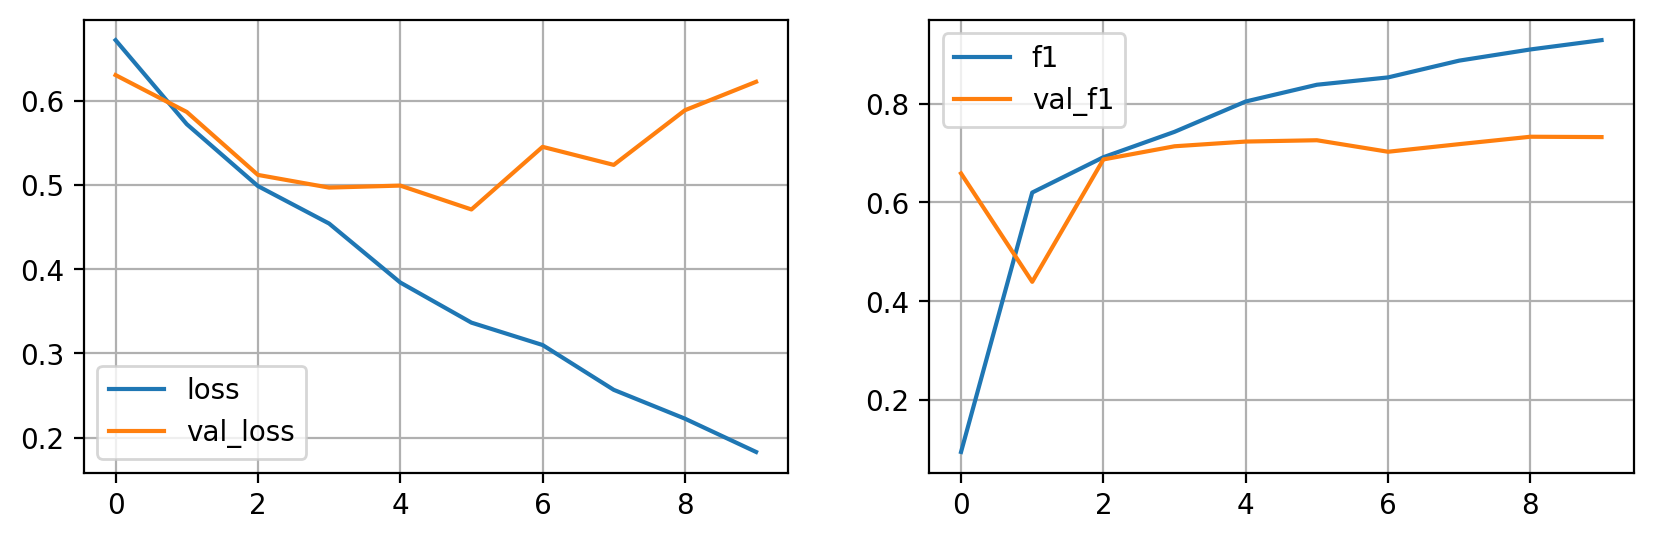

In [42]:
def plot(hist):
    fig = plt.figure(dpi=200,figsize=(10,3))
    ax = plt.subplot(121)
    hist = pd.DataFrame(hist)
    hist[['loss', 'val_loss']].plot(ax=ax, grid=True)
    ax = plt.subplot(122)
    hist[['f1', 'val_f1']].plot(ax=ax, grid=True)
    plt.show()
    
plot(hist)

In [43]:
test_dataset = torchtext.data.TabularDataset(
    path = PATH / 'test.csv',
    format = 'CSV',
    fields = [('id', ID), ('keyword', KEYWORD), ('location', LOCATION), ('text', TEXT)],
    skip_header = True
)

len(test_dataset)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


3263

In [44]:
ix = 3258
print(vars(test_dataset.examples[ix]))

{'id': '10861', 'keyword': '', 'location': '', 'text': ['EARTHQUAKE', 'SAFETY', 'LOS', 'ANGELES', '\x89ÛÒ', 'SAFETY', 'FASTENERS', 'XrWn']}


In [45]:
test_dataloader = torchtext.data.BucketIterator(test_dataset, batch_size=64, shuffle=False, device=device)

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [46]:
def predict():
    model.eval()
    preds = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch in test_dataloader:
            y_pred = model(batch.text)        
            y_pred = torch.argmax(y_pred, axis=1)
            preds = torch.cat([preds, y_pred])
    return preds

In [47]:
preds = predict()
preds

C:\Users\sensio\miniconda3\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


tensor([1., 1., 1.,  ..., 1., 0., 0.], device='cuda:0')

In [48]:
submission = pd.read_csv(PATH  / 'sample_submission.csv')
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [49]:
submission.target = preds.cpu().long()
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0


In [50]:
submission.to_csv('submission.csv', index=False)